In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [6]:
# Load the dataset
data = pd.read_csv('googleplaystore.csv')
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [8]:
# Data Cleaning
# Convert 'Last Updated' to datetime format
data['Last Updated'] = pd.to_datetime(data['Last Updated'], errors='coerce')

In [10]:
# Clean 'Installs' column by removing '+' and ',' then convert to integer
data['Installs'] = pd.to_numeric(data['Installs'].str.replace('[+,]', '', regex=True), errors='coerce')
data['Installs'] = data['Installs'].fillna(0).astype(int) # Replace NaN with 0 and convert to int

In [12]:
# Clean 'Size' column and convert to numeric (handling 'Varies with device')
data['Size'] = data['Size'].replace('Varies with device', pd.NA)
data['Size'] = data['Size'].str.replace('M', 'e6').str.replace('k', 'e3')
data['Size'] = pd.to_numeric(data['Size'], errors='coerce')

In [14]:
# Convert 'Reviews' to numeric
data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce')

In [16]:
# Convert 'Rating' to numeric
data['Rating'] = pd.to_numeric(data['Rating'], errors='coerce')

In [18]:
# Function to check if the current time is within the allowed range
def is_time_allowed(start_hour, end_hour):
    current_hour = datetime.now().hour
    return start_hour <= current_hour < end_hour

## 1. Stacked Bar Chart: Sentiment Distribution

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15120\4158452171.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_data.groupby(['Category', 'Rating Group'])


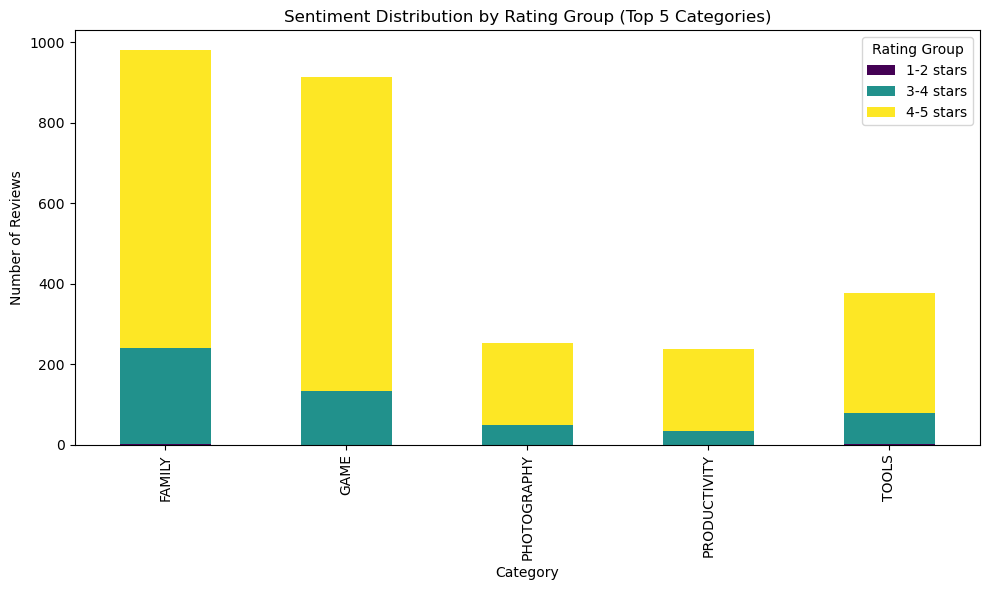

In [21]:
if not data.empty:
    filtered_data = data[data['Reviews'] > 1000]
    top_categories = filtered_data['Category'].value_counts().head(5).index
    
    filtered_data = filtered_data[filtered_data['Category'].isin(top_categories)]
    filtered_data['Rating Group'] = pd.cut(
        filtered_data['Rating'],
        bins=[0, 2, 4, 5],
        labels=['1-2 stars', '3-4 stars', '4-5 stars']
    )

    sentiment_distribution = (
        filtered_data.groupby(['Category', 'Rating Group'])
        .size()
        .unstack(fill_value=0)
    )

    sentiment_distribution.plot(
        kind='bar', stacked=True, figsize=(10, 6), cmap='viridis'
    )
    plt.title('Sentiment Distribution by Rating Group (Top 5 Categories)')
    plt.xlabel('Category')
    plt.ylabel('Number of Reviews')
    plt.legend(title='Rating Group')
    plt.tight_layout()
    plt.show()

## 2. Grouped Bar Chart: Average Rating and Total Reviews

In [24]:
if is_time_allowed(15, 17):
    filtered_data = data[
        (data['Rating'] >= 4.0) &
        (data['Size'] >= 10_000_000) &
        (data['Last Updated'].dt.month == 1)
    ]

    if not filtered_data.empty:
        # Identify top 10 categories by number of installs
        top_categories = filtered_data.groupby('Category')['Installs'].sum().nlargest(10).index
        filtered_data = filtered_data[filtered_data['Category'].isin(top_categories)]

        # Calculate average rating and total reviews for each category
        avg_rating = filtered_data.groupby('Category')['Rating'].mean()
        total_reviews = filtered_data.groupby('Category')['Reviews'].sum()

        # Plotting the grouped bar chart
        bar_width = 0.4
        categories = avg_rating.index
        x = range(len(categories))

        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Average Rating Bars
        ax1.bar(x, avg_rating, bar_width, label='Average Rating', color='blue', alpha=0.7)
        # Total Reviews Bars
        ax1.bar([p + bar_width for p in x], total_reviews / 1e6, bar_width, label='Total Reviews (in Millions)', color='orange', alpha=0.7)

        # Configure x-axis
        ax1.set_xticks([p + bar_width / 2 for p in x])
        ax1.set_xticklabels(categories, rotation=45, ha='right')
        ax1.set_title('Comparison of Average Rating and Total Reviews (Top 10 Categories)')
        ax1.set_xlabel('Category')
        ax1.set_ylabel('Value')
        ax1.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No data available for the specified criteria.")
else:
    print("This graph is not available outside the allowed time (3 PM to 5 PM IST).")

This graph is not available outside the allowed time (3 PM to 5 PM IST).


## 3. Time Series Line Chart: Install Trends

In [29]:
if is_time_allowed(18, 21):
    filtered_data = data[
        (data['Content Rating'] == 'Teen') &
        (data['App'].str.startswith('E')) &
        (data['Installs'] > 10_000)
    ]

    if not filtered_data.empty:
        filtered_data['Month'] = filtered_data['Last Updated'].dt.to_period('M')
        installs_trend = filtered_data.groupby(['Month', 'Category'])['Installs'].sum().unstack()

        ax = installs_trend.plot(kind='line', figsize=(12, 6), marker='o')
        
        for category in installs_trend.columns:
            growth = installs_trend[category].pct_change() > 0.2
            ax.fill_between(
                installs_trend.index.to_timestamp(),
                installs_trend[category],
                where=growth,
                alpha=0.3
            )

        plt.title('Install Trends Over Time (Highlighted Growth > 20%)')
        plt.xlabel('Time')
        plt.ylabel('Total Installs')
        plt.legend(title='Category')
        plt.tight_layout()
        plt.show()
    else:
        print("No data available for the specified criteria.")
else:
    print("This graph is not available outside the allowed time (6 PM to 9 PM IST).")

This graph is not available outside the allowed time (6 PM to 9 PM IST).
